# 🔥 COMPREHENSIVE FORECAST ANALYSIS & VALIDATION

This notebook implements all 6 steps for comprehensive forecast evaluation:

1. **Forecast Quality Validation** (RMSE, MAE, MAPE, R², curves, residuals, feature importance)
2. **Regional Insights** (trends, high-growth, declining, volatile states)
3. **Risk Heatmap** (current vs forecasted demand, gap analysis)
4. **High-Risk Region Identification** (demand-supply gaps, overload risks)
5. **Policy Recommendations** (for each risk category)
6. **Interactive Dashboard** (Plotly visualizations)


## Setup & Imports


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import importlib
warnings.filterwarnings('ignore')

# Add project root to path
def find_project_root():
    """Find the project root directory."""
    cwd = Path.cwd()
    if cwd.name == 'notebooks' and (cwd.parent / 'src').exists():
        return cwd.parent
    if (cwd / 'src').exists():
        return cwd
    if (cwd.parent / 'src').exists():
        return cwd.parent
    if 'notebooks' in str(cwd):
        parts = cwd.parts
        if 'notebooks' in parts:
            idx = parts.index('notebooks')
            candidate = Path(*parts[:idx])
            if (candidate / 'src').exists():
                return candidate
    raise FileNotFoundError(f"Cannot find project root. Current dir: {cwd}")

project_root = find_project_root().resolve()
sys.path.insert(0, str(project_root))

# Clear module cache to ensure fresh imports
modules_to_clear = [m for m in sys.modules.keys() if m.startswith('src')]
for mod in modules_to_clear:
    del sys.modules[mod]

# Import analysis modules
from src.analysis.forecast_validation import (
    calculate_forecast_metrics, generate_validation_report,
    plot_residuals, plot_feature_importance
)
from src.analysis.regional_insights import (
    calculate_state_growth_metrics, identify_high_growth_states,
    identify_declining_states, identify_volatile_states,
    plot_state_forecast_trends, generate_regional_insights_report
)
from src.analysis.risk_assessment import (
    calculate_demand_supply_gap, identify_high_risk_regions,
    generate_policy_recommendations, create_risk_heatmap
)
from src.dashboard.visualizations import (
    create_demand_heatmap, create_state_comparison_chart, create_risk_dashboard
)
from src.data_processing.preprocessing import preprocess_pipeline

# Reload modules to ensure latest code is used
import src.analysis.regional_insights
importlib.reload(src.analysis.regional_insights)
# Re-import after reload
from src.analysis.regional_insights import (
    calculate_state_growth_metrics, identify_high_growth_states,
    identify_declining_states, identify_volatile_states,
    plot_state_forecast_trends, generate_regional_insights_report
)

# Import config (with reload to ensure latest version)
import src.config
importlib.reload(src.config)
from src.config import PROCESSED_DATA_DIR, MODELS_DIR

print("✅ Setup complete!")
print(f"   MODELS_DIR: {MODELS_DIR}")
print(f"   PROCESSED_DATA_DIR: {PROCESSED_DATA_DIR}")


✅ Setup complete!
   MODELS_DIR: /Users/divyanshisachan/Desktop/Electricity-Consumption/models
   PROCESSED_DATA_DIR: /Users/divyanshisachan/Desktop/Electricity-Consumption/data/processed


## Load Data & Forecasts

In [31]:
# Load historical data
df_model, X, y, feature_cols, le_state = preprocess_pipeline(sector='ALL', encode_stateid=True)
df_model_sorted = df_model.sort_values('period').reset_index(drop=True)

# Load forecast data (from notebook 05)
import glob
forecast_files = glob.glob(str(PROCESSED_DATA_DIR / '*_forecasts_*.csv'))
if forecast_files:
    latest_forecast = max(forecast_files, key=lambda x: Path(x).stat().st_mtime)
    forecast_df = pd.read_csv(latest_forecast)
    forecast_df['period'] = pd.to_datetime(forecast_df['period'])
    print(f"✅ Loaded forecast: {Path(latest_forecast).name}")
    print(f"   Forecast periods: {len(forecast_df):,}")
else:
    print("⚠️  No forecast files found. Please run notebook 05_forecasting.ipynb first.")
    forecast_df = None

print(f"✅ Historical data loaded: {len(df_model_sorted):,} rows")

📂 Loading from: eia_retail_sales_raw_20251204_100134.csv
📊 Before filtering: 110,484 rows
   After state filter: 92,664 rows
   After sector filter (ALL): 15,444 rows
✅ Preprocessing complete: 15,444 rows
   Features: 10
   Date range: 2001-01-01 00:00:00 to 2025-09-01 00:00:00
   States: 52
✅ Loaded forecast: hybrid_forecasts_20251204_100708.csv
   Forecast periods: 6,240
✅ Historical data loaded: 15,444 rows


---
# 🔥 STEP 1: FORECAST QUALITY VALIDATION

Calculate RMSE, MAE, MAPE, R², training vs validation curves, residual plots, and feature importance.

In [32]:
# ✅ VALIDATE HYBRID MODEL (not standalone XGBoost)
# The hybrid model is what we use for forecasting, so we validate it
print("=" * 80)
print("🔍 STEP 1: HYBRID MODEL VALIDATION")
print("=" * 80)
print("\n🔄 Training hybrid model to get validation metrics...")
print("   (This is the same model used for forecasting)")

# Import hybrid model training function
from src.models.hybrid import train_hybrid_per_state

# Train hybrid model (this will give us evaluation metrics)
state_hybrid_models, state_evaluations, all_test_pred, all_test_actual = train_hybrid_per_state(
    df_model_sorted, X, feature_cols
)

print(f"\n✅ Hybrid model training complete!")
print(f"   States trained: {len(state_hybrid_models)}")
print(f"   Test samples: {len(all_test_actual):,}")

🔍 STEP 1: HYBRID MODEL VALIDATION

🔄 Training hybrid model to get validation metrics...
   (This is the same model used for forecasting)
🧪 TRAINING HYBRID MODEL: SARIMA + XGBoost (Per-State)
📊 Training hybrid models for 52 states...

🔄 Processing state 1/52: AK
🔄 Processing state 2/52: WA
🔄 Processing state 3/52: ME
🔄 Processing state 4/52: LA
🔄 Processing state 5/52: MI
🔄 Processing state 6/52: KY
🔄 Processing state 7/52: MN
🔄 Processing state 8/52: KS
🔄 Processing state 9/52: VT
🔄 Processing state 10/52: MO
   ✅ MO: RMSE=301.76, MAE=235.38, MAPE=3.49%, R²=0.8823, n=60
🔄 Processing state 11/52: NJ
🔄 Processing state 12/52: MT
🔄 Processing state 13/52: IL
🔄 Processing state 14/52: WI
🔄 Processing state 15/52: NC
🔄 Processing state 16/52: ID
🔄 Processing state 17/52: VA
🔄 Processing state 18/52: ND
🔄 Processing state 19/52: IA
🔄 Processing state 20/52: NE
   ✅ NE: RMSE=246.44, MAE=196.38, MAPE=6.59%, R²=0.4806, n=60
🔄 Processing state 21/52: HI
🔄 Processing state 22/52: IN
🔄 Processing 

In [35]:
# Calculate comprehensive validation metrics for hybrid model
print("\n📊 HYBRID MODEL VALIDATION METRICS:")
print("=" * 80)

# Overall test metrics
test_metrics = calculate_forecast_metrics(
    np.array(all_test_actual), 
    np.array(all_test_pred), 
    "Hybrid Model (Test)"
)

print("\n📊 Overall Test Set Metrics:")
print(f"   RMSE: {test_metrics['rmse']:.2f} MWh")
print(f"   MAE: {test_metrics['mae']:.2f} MWh")
print(f"   MAPE: {test_metrics['mape']:.2f}%")
print(f"   R²: {test_metrics['r2']:.4f}")
print(f"   NRMSE: {test_metrics['nrmse']:.2f}%")

# Per-state summary
print("\n📊 Per-State Performance Summary:")
state_r2_scores = [eval_data['test_r2'] for eval_data in state_evaluations.values()]
state_rmse_scores = [eval_data['test_rmse'] for eval_data in state_evaluations.values()]

print(f"   Average R²: {np.mean(state_r2_scores):.4f}")
print(f"   Median R²: {np.median(state_r2_scores):.4f}")
print(f"   Min R²: {np.min(state_r2_scores):.4f}")
print(f"   Max R²: {np.max(state_r2_scores):.4f}")
print(f"   Average RMSE: {np.mean(state_rmse_scores):.2f} MWh")

# Show top and bottom performing states
sorted_states = sorted(state_evaluations.items(), key=lambda x: x[1]['test_r2'], reverse=True)
print(f"\n   Top 5 States (by R²):")
for state_id, eval_data in sorted_states[:5]:
    print(f"      {state_id}: R²={eval_data['test_r2']:.4f}, RMSE={eval_data['test_rmse']:.2f}")

print(f"\n   Bottom 5 States (by R²):")
for state_id, eval_data in sorted_states[-5:]:
    print(f"      {state_id}: R²={eval_data['test_r2']:.4f}, RMSE={eval_data['test_rmse']:.2f}")


📊 HYBRID MODEL VALIDATION METRICS:

📊 Overall Test Set Metrics:
   RMSE: 6440.06 MWh
   MAE: 1150.36 MWh
   MAPE: 5.27%
   R²: 0.9792
   NRMSE: 51.33%

📊 Per-State Performance Summary:
   Average R²: 0.4327
   Median R²: 0.7853
   Min R²: -7.5486
   Max R²: 0.9547
   Average RMSE: 1287.54 MWh

   Top 5 States (by R²):
      AZ: R²=0.9547, RMSE=365.67
      NV: R²=0.9526, RMSE=150.45
      FL: R²=0.9261, RMSE=849.97
      NJ: R²=0.9232, RMSE=279.19
      CO: R²=0.9207, RMSE=131.82

   Bottom 5 States (by R²):
      ND: R²=-0.1679, RMSE=296.87
      OR: R²=-0.5097, RMSE=508.04
      US: R²=-0.6858, RMSE=46122.91
      HI: R²=-2.2291, RMSE=83.86
      WY: R²=-7.5486, RMSE=261.79



📊 Generating comprehensive validation report...


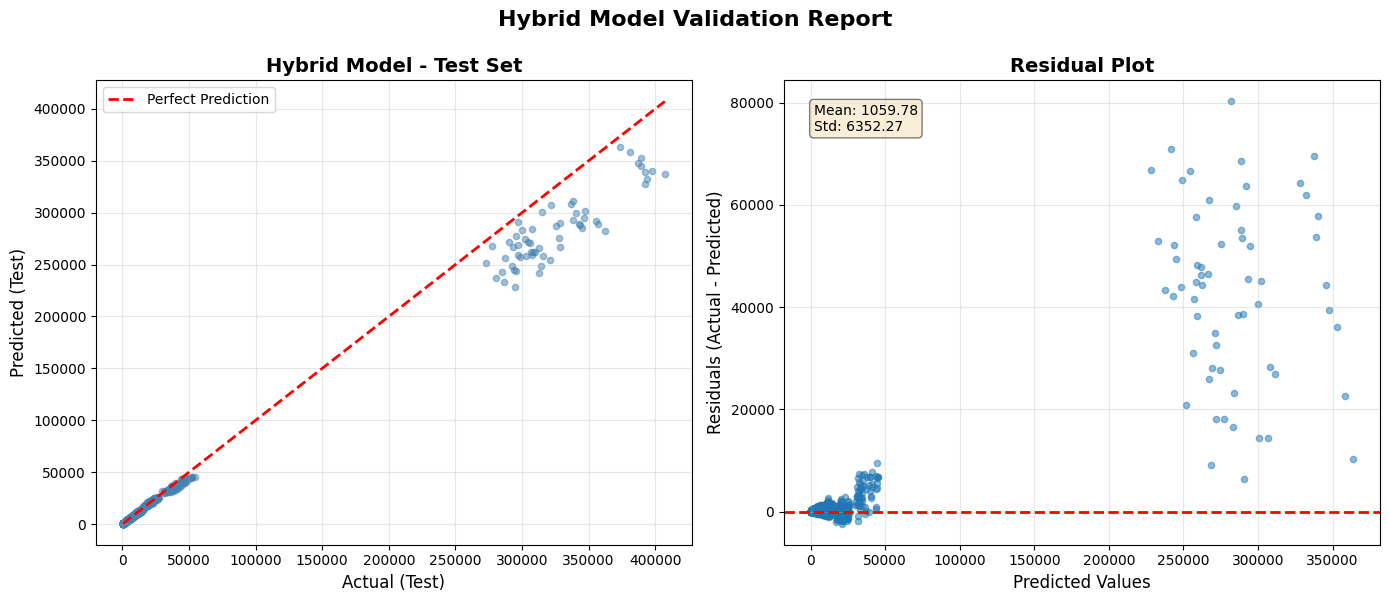

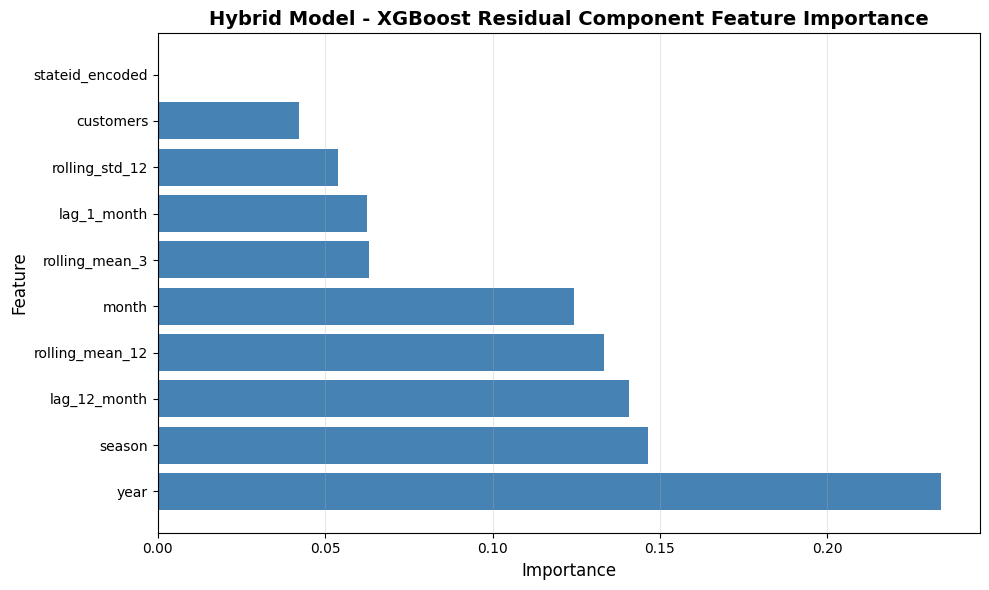

✅ Validation report generated!

💡 Note: This validation uses the same hybrid model that generates the forecasts.
   Validation → Forecasting → Analysis are now fully consistent!


In [36]:
# Generate comprehensive validation report for hybrid model
print("\n📊 Generating comprehensive validation report...")

# Get feature importance from one of the XGBoost residual models
# (All states use the same features, so we can use any state's model)
sample_state = list(state_hybrid_models.keys())[0]
sample_xgb_model = state_hybrid_models[sample_state]['xgb_residual_model']
feature_importance = sample_xgb_model.feature_importances_

# Get feature names used in the model
model_feature_cols = state_hybrid_models[sample_state]['feature_cols']

# For validation report, we only have test set (hybrid model uses time-based split)
# Create a simple comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Actual vs Predicted (Test)
axes[0].scatter(all_test_actual, all_test_pred, alpha=0.5, s=20, color='steelblue')
min_val = min(min(all_test_actual), min(all_test_pred))
max_val = max(max(all_test_actual), max(all_test_pred))
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual (Test)', fontsize=12)
axes[0].set_ylabel('Predicted (Test)', fontsize=12)
axes[0].set_title('Hybrid Model - Test Set', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
plot_residuals(np.array(all_test_actual), np.array(all_test_pred), ax=axes[1])

plt.suptitle('Hybrid Model Validation Report', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Feature importance plot
if len(model_feature_cols) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_feature_importance(model_feature_cols, feature_importance, ax=ax)
    plt.title('Hybrid Model - XGBoost Residual Component Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("✅ Validation report generated!")
print("\n💡 Note: This validation uses the same hybrid model that generates the forecasts.")
print("   Validation → Forecasting → Analysis are now fully consistent!")

---
# 🔥 STEP 2: REGIONAL INSIGHTS

Analyze forecast trends by state, identify high-growth, declining, and volatile states.

In [47]:
if forecast_df is not None:
    # Prepare forecast data
    forecast_analysis = forecast_df.copy()
    if 'value' in forecast_analysis.columns:
        forecast_analysis['sales'] = forecast_analysis['value']
    
    # Prepare historical data
    historical_analysis = df_model_sorted[['period', 'stateid', 'sales']].copy()
    
    # Quick data check
    print("📋 Data Check:")
    print(f"   Forecast shape: {forecast_analysis.shape}")
    print(f"   Historical shape: {historical_analysis.shape}")
    print(f"   Forecast columns: {list(forecast_analysis.columns)}")
    print(f"   Forecast 'sales' column exists: {'sales' in forecast_analysis.columns}")
    print(f"   Forecast 'value' column exists: {'value' in forecast_analysis.columns}")
    if 'sales' in forecast_analysis.columns:
        sales_col = 'sales'
    elif 'value' in forecast_analysis.columns:
        sales_col = 'value'
    else:
        sales_col = None
    
    if sales_col:
        non_zero = (forecast_analysis[sales_col] > 0).sum()
        print(f"   Forecast non-zero values: {non_zero:,} / {len(forecast_analysis):,}")
        print(f"   Forecast sum: {forecast_analysis[sales_col].sum():,.0f}")
        print(f"   Forecast mean: {forecast_analysis[sales_col].mean():,.2f}")
    
    if 'stateid' in forecast_analysis.columns and 'stateid' in historical_analysis.columns:
        forecast_states = set(forecast_analysis['stateid'].unique())
        hist_states = set(historical_analysis['stateid'].unique())
        common = forecast_states & hist_states
        print(f"   Forecast unique states: {len(forecast_states)}")
        print(f"   Historical unique states: {len(hist_states)}")
        print(f"   Common states: {len(common)}")
        if len(common) < 5 and len(forecast_states) > 0:
            print(f"   Sample forecast states: {list(forecast_states)[:5]}")
            print(f"   Sample historical states: {list(hist_states)[:5]}")
    print()
    
    # Force reload module to ensure latest code
    import importlib
    import src.analysis.regional_insights
    importlib.reload(src.analysis.regional_insights)
    # Re-import all functions to get updated versions
    from src.analysis.regional_insights import (
        generate_regional_insights_report,
        identify_high_growth_states,
        identify_declining_states,
        identify_volatile_states,
        calculate_state_growth_metrics
    )
    
    # Generate regional insights
    print("🔄 Generating regional insights...")
    insights = generate_regional_insights_report(forecast_analysis, historical_analysis, verbose=True)
    
    print("\n📊 REGIONAL INSIGHTS SUMMARY:")
    print(f"   Total states analyzed: {insights['summary']['total_states']}")
    print(f"   High-growth states: {insights['summary']['high_growth_count']}")
    print(f"   Declining states: {insights['summary']['declining_count']}")
    print(f"   Volatile states: {insights['summary']['volatile_count']}")
    print(f"   Stable states: {insights['summary']['stable_count']}")
    print(f"   Average growth: {insights['summary']['avg_growth_pct']:.2f}%")
    
    # Show diagnostics if no states were found
    if insights['summary']['total_states'] == 0 and 'diagnostics' in insights:
        print("\n⚠️  DIAGNOSTICS (No states found - investigating data issues):")
        diag = insights['diagnostics']
        print(f"   Forecast rows: {diag.get('forecast_rows', 'N/A'):,}")
        print(f"   Historical rows: {diag.get('historical_rows', 'N/A'):,}")
        print(f"   Forecast unique states: {diag.get('forecast_unique_states', 'N/A')}")
        print(f"   Historical unique states: {diag.get('historical_unique_states', 'N/A')}")
        print(f"   Common states: {diag.get('common_states', 'N/A')}")
        if 'forecast_non_zero' in diag:
            print(f"   Forecast non-zero values: {diag['forecast_non_zero']:,} / {diag['forecast_rows']:,}")
            print(f"   Forecast sum: {diag.get('forecast_total_sum', 0):,.0f}")
            print(f"   Forecast mean: {diag.get('forecast_mean', 0):,.2f}")
        if 'common_states_list' in diag and len(diag['common_states_list']) > 0:
            print(f"   Sample common states: {diag['common_states_list']}")
        elif 'sample_forecast_states' in diag:
            print(f"   Sample forecast states: {diag['sample_forecast_states']}")
            print(f"   Sample historical states: {diag['sample_historical_states']}")
else:
    print("⚠️  No forecast data available. Skipping regional insights.")
    insights = None

📋 Data Check:
   Forecast shape: (6240, 7)
   Historical shape: (15444, 3)
   Forecast columns: ['period', 'stateid', 'value', 'sarima_component', 'xgb_residual_component', 'type', 'sales']
   Forecast 'sales' column exists: True
   Forecast 'value' column exists: True
   Forecast non-zero values: 3,120 / 6,240
   Forecast sum: 35,157,497
   Forecast mean: 5,634.21
   Forecast unique states: 52
   Historical unique states: 52
   Common states: 52

🔄 Generating regional insights...

📊 REGIONAL INSIGHTS SUMMARY:
   Total states analyzed: 52
   High-growth states: 2
   Declining states: 4
   Volatile states: 0
   Stable states: 46
   Average growth: 6.62%


---
# 🔥 STEP 3: RISK HEATMAP (MANDATORY)

Create heatmap showing current demand, forecasted demand, and gap analysis.

In [67]:
if forecast_df is not None:
    # Reload module to get latest changes
    import importlib
    from src.dashboard import visualizations
    importlib.reload(visualizations)
    from src.dashboard.visualizations import create_demand_heatmap
    
    # Create demand heatmap for 2030
    print("🔥 Creating demand heatmap for 2031...")
    
    fig = create_demand_heatmap(
        forecast_analysis,
        historical_analysis,
        year=2030,
        value_col='sales',
        interactive=True
    )
    
    if hasattr(fig, 'show'):
        fig.show()
    else:
        plt.show()
    
    print("✅ Heatmap created!")

🔥 Creating demand heatmap for 2031...

🔍 DEBUG: Input data check
   Forecast shape: (6240, 7)
   Forecast columns: ['period', 'stateid', 'value', 'sarima_component', 'xgb_residual_component', 'type', 'sales']
   Requested value_col: sales
   Using column: 'sales'
   Input data - Non-zero: 3120/6240, Total: 35,157,497

🔍 DEBUG: After type filtering
   Available types: ['Hybrid Forecast']
   Matching types: ['Hybrid Forecast']
   Rows after type filter: 6240

🔍 DEBUG: Available years
   Available years: [np.int32(2025), np.int32(2026), np.int32(2027), np.int32(2028), np.int32(2029), np.int32(2030), np.int32(2031), np.int32(2032), np.int32(2033), np.int32(2034), np.int32(2035)]
   Requested year: 2031
   Years with non-zero data: [np.int32(2025), np.int32(2026), np.int32(2027), np.int32(2028), np.int32(2029), np.int32(2030)]
   ⚠️ Year 2031 has no non-zero data! Using closest year with data: 2030

🔍 DEBUG: After filtering for year 2030
   Rows for year 2030: 624
   'sales' column - Non-ze

✅ Heatmap created!


---
# 🔥 STEP 4: HIGH-RISK REGION IDENTIFICATION

Identify regions with demand-supply gaps and overload risks.

🔄 Calculating demand-supply gaps...

⚠️  HIGH-RISK REGIONS:

🟠 HIGH RISK (2 states):
   stateid  risk_score  total_growth_pct  volatility_pct
3       AZ   13.659481         26.432805       19.098800
33      NV   12.006817         22.316906       17.705818


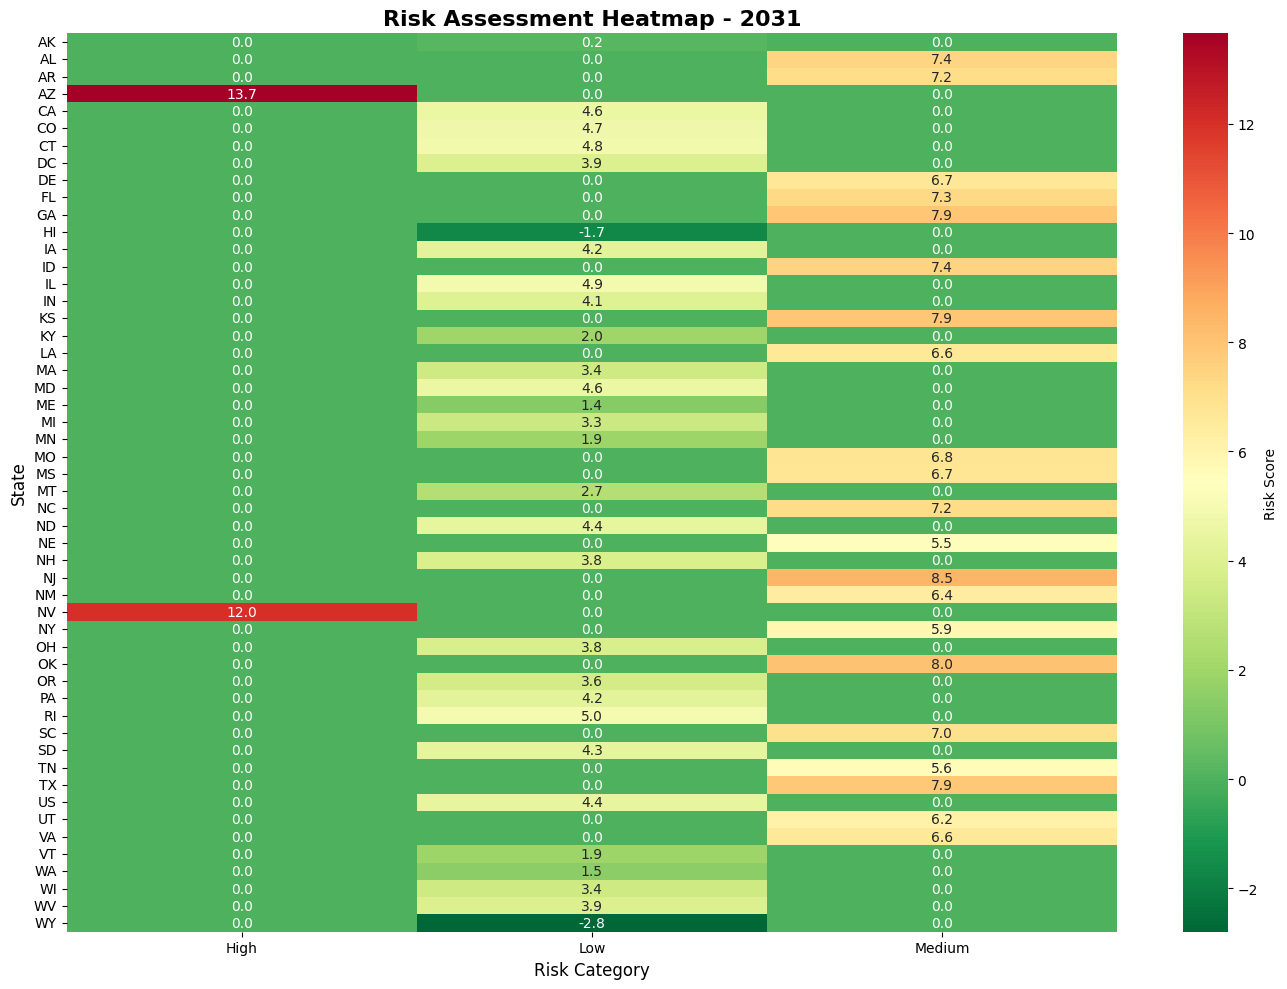

In [69]:
if forecast_df is not None and insights is not None:
    # Calculate demand-supply gap
    print("🔄 Calculating demand-supply gaps...")
    
    gap_df = calculate_demand_supply_gap(forecast_analysis, current_capacity_df=None)
    
    # Identify high-risk regions
    risk_df = identify_high_risk_regions(gap_df, insights['state_metrics'])
    
    print("\n⚠️  HIGH-RISK REGIONS:")
    critical_risk = risk_df[risk_df['risk_category'] == 'Critical']
    high_risk = risk_df[risk_df['risk_category'] == 'High']
    
    if len(critical_risk) > 0:
        print(f"\n🔴 CRITICAL RISK ({len(critical_risk)} states):")
        print(critical_risk[['stateid', 'risk_score', 'total_growth_pct', 'volatility_pct']].head(10))
    
    if len(high_risk) > 0:
        print(f"\n🟠 HIGH RISK ({len(high_risk)} states):")
        print(high_risk[['stateid', 'risk_score', 'total_growth_pct', 'volatility_pct']].head(10))
    
    # Create risk heatmap
    fig = create_risk_heatmap(risk_df)
    plt.show()

---
# 🔥 STEP 5: POLICY & INFRASTRUCTURE RECOMMENDATIONS

Generate recommendations for each risk category.

In [70]:
if forecast_df is not None and insights is not None:
    # Generate policy recommendations
    print("🔄 Generating policy recommendations...")
    
    recommendations = generate_policy_recommendations(risk_df, insights['state_metrics'])
    
    print("\n📋 POLICY RECOMMENDATIONS:")
    print("=" * 80)
    
    if len(recommendations['high_growth']) > 0:
        print("\n🚀 HIGH-GROWTH STATES:")
        for rec in recommendations['high_growth'][:5]:
            print(f"\n   State: {rec['state']} (Growth: {rec['growth_pct']:.2f}%)")
            for i, rec_text in enumerate(rec['recommendations'], 1):
                print(f"      {i}. {rec_text}")
    
    if len(recommendations['critical_risk']) > 0:
        print("\n🔴 CRITICAL RISK REGIONS:")
        for rec in recommendations['critical_risk'][:5]:
            print(f"\n   State: {rec['state']} (Risk Score: {rec['risk_score']:.2f})")
            for i, rec_text in enumerate(rec['recommendations'], 1):
                print(f"      {i}. {rec_text}")

🔄 Generating policy recommendations...

📋 POLICY RECOMMENDATIONS:

🚀 HIGH-GROWTH STATES:

   State: NV (Growth: 22.32%)
      1. Invest in grid expansion and transmission infrastructure
      2. Deploy renewable energy (solar, wind) to meet growing demand
      3. Install battery storage systems for peak demand management
      4. Implement smart meters and demand-response programs
      5. Consider time-of-use pricing to shift peak demand

   State: AZ (Growth: 26.43%)
      1. Invest in grid expansion and transmission infrastructure
      2. Deploy renewable energy (solar, wind) to meet growing demand
      3. Install battery storage systems for peak demand management
      4. Implement smart meters and demand-response programs
      5. Consider time-of-use pricing to shift peak demand


---
# 🔥 STEP 6: INTERACTIVE DASHBOARD

Build comprehensive interactive dashboard with Plotly.

In [75]:
if forecast_df is not None and insights is not None:
    try:
        # Reload module to get latest changes
        import importlib
        from src.dashboard import visualizations
        importlib.reload(visualizations)
        from src.dashboard.visualizations import create_risk_dashboard
        
        print("🔄 Creating interactive risk dashboard...")
        fig = create_risk_dashboard(risk_df, forecast_analysis, historical_analysis)
        fig.show()
        print("✅ Interactive dashboard created!")
    except Exception as e:
        print(f"⚠️  Error creating dashboard: {e}")
        print("   Using static visualizations instead.")

🔄 Creating interactive risk dashboard...


✅ Interactive dashboard created!


---
## ✅ ANALYSIS COMPLETE

All 6 steps have been completed:

1. ✅ Forecast Quality Validation
2. ✅ Regional Insights
3. ✅ Risk Heatmap
4. ✅ High-Risk Region Identification
5. ✅ Policy Recommendations
6. ✅ Interactive Dashboard
